In [46]:
import tqdm
import math
import optuna
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import KBinsDiscretizer
from category_encoders import BinaryEncoder, one_hot
from sklearn.model_selection import train_test_split, StratifiedKFold

In [47]:
import warnings
warnings.filterwarnings('ignore')

In [48]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')
sample_submission = pd.read_csv('data/sample_submission.csv')

In [49]:
train_df

,age,country,city,school,faculty,student_id,sociodemographics,test_score,application_id,personal_statement,accepted
0,24,Россия,Санкт-Петербург,9,0,7127004,1f63c614a798186e5b5dbca02201a070,21.0,06c4288fba116e49f49d82a16184fca6,NaN,0.0
1,21,Казахстан,Астана,5,0,6264436,99fec0c12216abee9eec3bee2138754f,29.0,45273a0d372f7f2747afc98bdc63c31a,NaN,1.0
2,17,Россия,Тула,3,0,9056805,f733e24fc7ae975aab7c3e092b1ae96c,89.0,773c820049150b6854691b5e7fdcd63f,NaN,0.0
3,20,Украина,Киев,1,0,8857612,a2b7795cd58502654754ce03163a1685,2.0,d07f757f1b51f8b9189a84298b142794,NaN,0.0
4,19,Россия,Пермь,8,0,6422527,90519fbbfd457329160e9c1767cb0a86,23.0,269f19b2ef9f46af5012931bfd4acf22,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...
95995,21,Россия,Улан-Удэ,5,5,2019496,e065aa14d0861cb2e8c227049bc0b1d3,73.0,4c33d89befc11bea800221a9d8719549,NaN,1.0
95996,18,Казахстан,Шымкент,9,5,1202270,de6753fb488b87117296d8bef2edc7b3,91.0,b76e187984d8b80264b4c97fac124f84,NaN,0.0
95997,18,Россия,Владивосток,14,5,4114792,7ebd9ffcf2f9f0fbe6cfd54917af2098,31.0,750e34ebbf17be247c9184149109cbdd,NaN,1.0
95998,20,Украина,Запорожье,2,5,5024696,a2b7795cd58502654754ce03163a1685,45.0,0a17ffcb17a2ffd2eb185ac793ed444e,NaN,1.0


In [104]:
n = 0

Text(0.5, 1.0, 'Санкт-Петербург')

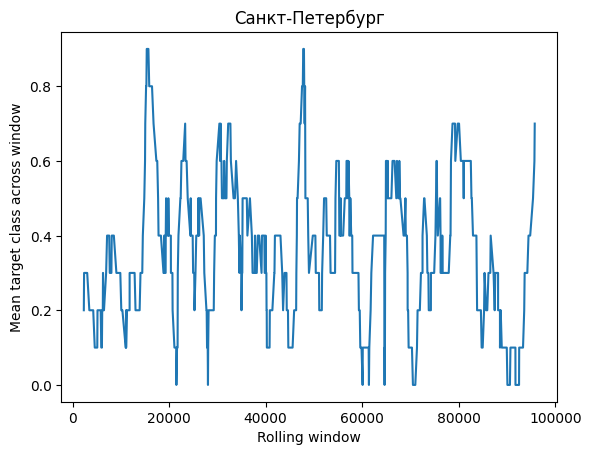

In [109]:
import matplotlib.pyplot as plt
plt.plot(train_df[train_df['city'] == train_df['city'].unique()[n]]['accepted'].rolling(10).mean())
plt.xlabel('Rolling window')
plt.ylabel('Mean target class across window')
plt.title(train_df['city'].unique()[n])

In [103]:
len(train_df[train_df['city'] == train_df['city'].unique()[n]])

583

Text(0.5, 1.0, 'Астана')

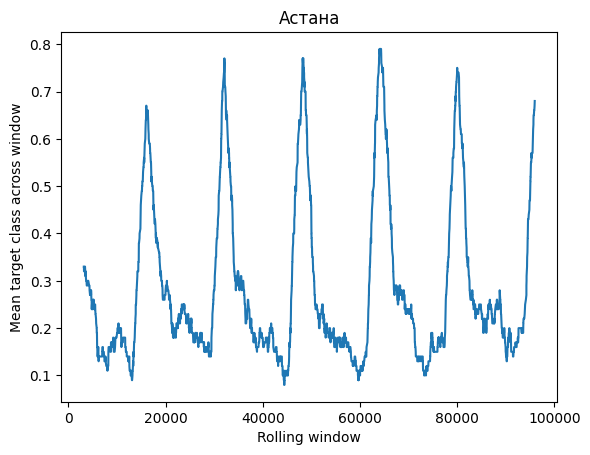

In [50]:
import matplotlib.pyplot as plt
plt.plot(train_df[train_df['city'] == 'Астана']['accepted'].rolling(100).mean())
plt.xlabel('Rolling window')
plt.ylabel('Mean target class across window')
plt.title('Астана')

Text(0.5, 1.0, 'Санкт-Петербург')

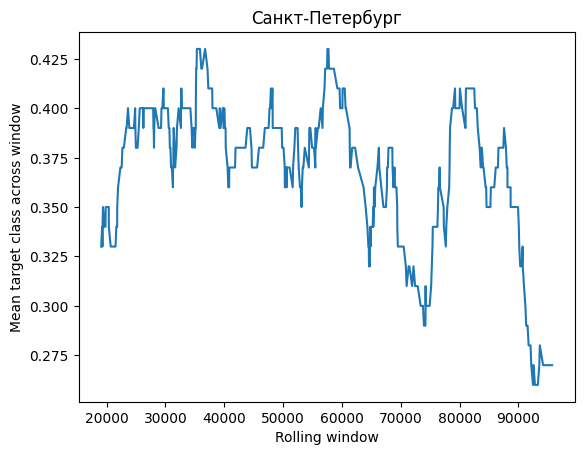

In [51]:
import matplotlib.pyplot as plt
plt.plot(train_df[train_df['city'] == 'Санкт-Петербург']['accepted'].rolling(100).mean())
plt.xlabel('Rolling window')
plt.ylabel('Mean target class across window')
plt.title('Санкт-Петербург')

Text(0.5, 1.0, 'Москва')

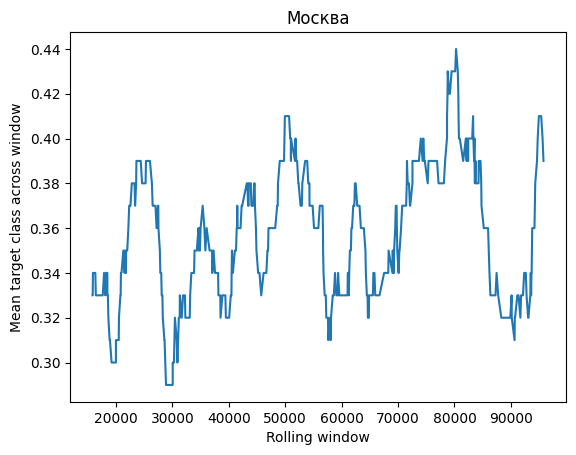

In [52]:
import matplotlib.pyplot as plt
plt.plot(train_df[train_df['city'] == 'Москва']['accepted'].rolling(100).mean())
plt.xlabel('Rolling window')
plt.ylabel('Mean target class across window')
plt.title('Москва')

Text(0.5, 1.0, 'Киев')

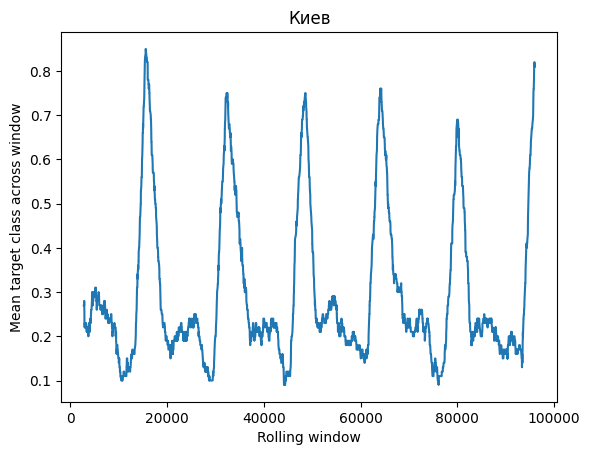

In [53]:
import matplotlib.pyplot as plt
plt.plot(train_df[train_df['city'] == 'Киев']['accepted'].rolling(100).mean())
plt.xlabel('Rolling window')
plt.ylabel('Mean target class across window')
plt.title('Киев')

In [54]:
test_df

,ID,age,country,city,school,faculty,student_id,sociodemographics,test_score,application_id,personal_statement
0,96000,21,Россия,Санкт-Петербург,9,0,4428545,adcb62fdc1121af780dc4138486cc7e3,63.0,700db6161a195963a89ee91a11bc6449,NaN
1,96001,22,Казахстан,Астана,5,0,4828171,05ec3873d1ced60fb3d4327bfd368e00,62.0,c818a649e468d97325813b877fb7f308,NaN
2,96002,23,Россия,Тула,3,0,6305415,1533b17f2c49fec036550ee67955b0a6,17.0,0cc80bc0aa8531794601980c4c2f0fb7,NaN
3,96003,17,Украина,Киев,1,0,5175385,f1eef626c29a481a5527d242ae5516a8,25.0,ed05d43a670eea5a75662cc82d3a4b7d,NaN
4,96004,24,Россия,Пермь,8,0,1809466,67086df93882a3958b6163a60d0bd6b5,64.0,7b3e7852822d85f1de686caeb0c6307d,NaN
...,...,...,...,...,...,...,...,...,...,...,...
23995,119995,24,Украина,Запорожье,9,5,4222406,c35fb088b2e889aeb1f99fc9d21292a5,38.0,566ef31470ee65f6f9ab087dedee4f62,NaN
23996,119996,17,Украина,Запорожье,12,5,4382550,bfbca9e6c1e7d0b3e670af72336b6e60,90.0,0f67dbe83cb72c6b8b3bbb89c9cc6d02,NaN
23997,119997,17,Казахстан,Алматы,2,5,2780558,56b4da4b9f916a54be39f26757c8ce14,78.0,e8e86ee3af0ba2f4408c08a8f431b284,NaN
23998,119998,18,Казахстан,Астана,5,5,1773219,ce33a4a84820e71f4f0b507d574c4146,90.0,444d9437a6e57a722715af2feab9ce82,NaN


In [55]:
# PASHALKO #1
((pd.concat([train_df, test_df], axis=0).groupby(['sociodemographics', 'application_id'])['accepted'].agg('count') == 2) * (pd.concat([train_df, test_df], axis=0).groupby(['sociodemographics', 'application_id'])['accepted'].agg('sum')) == (pd.concat([train_df, test_df], axis=0).groupby(['sociodemographics', 'application_id'])['accepted'].agg('count') == 2).astype('float')).all()

True

In [56]:
# PASHALKO #2
train_df[train_df['test_score'] % 1 > 0].groupby(['student_id', 'application_id'])['accepted'].agg('max').min()

1.0

In [57]:
# train_df['application_id'] = train_df['application_id'].apply(lambda x: math.log(int(x, 16), 2)).astype(float)
# test_df['application_id'] = test_df['application_id'].apply(lambda x: math.log(int(x, 16), 2)).astype(float)

# PASHALKO #3
train_df['application_id'] = train_df['application_id'].apply(lambda x: int(x, 16))
test_df['application_id'] = test_df['application_id'].apply(lambda x: int(x, 16))

In [58]:
# PASHALKO #4
train_df['student_id_%'] = train_df['student_id'] % 100
test_df['student_id_%'] = test_df['student_id'] % 100

In [59]:
train_df['application_id_%'] = train_df['application_id'] % 250
test_df['application_id_%'] = test_df['application_id'] % 250

In [60]:
leaky_cities = []
for city in train_df['city'].unique():
    rw = train_df[train_df['city'] == city]['accepted'].rolling(100).mean()
    if rw.max() >= 0.8 or rw.min() <= 0.2:
        leaky_cities.append(city)
        print(city)

Астана
Киев
Харьков
Минск
Одесса
Брест
Гродно
Запорожье
Шымкент
Актобе
Витебск
Гомель
Львов
Днепр
Караганда
Актау
Могилёв
Алматы
Кривой Рог
Павлодар


In [61]:
# PASHALKO #6
train_df['cool_feature'] = train_df.groupby('faculty').cumcount() / train_df.groupby('faculty').transform('size')
discretizer = KBinsDiscretizer(n_bins=40, encode='ordinal', strategy='uniform')
train_df['cool_feature'] = discretizer.fit_transform(train_df[['cool_feature']])[:, 0]
mapl = train_df[train_df['city'].isin(leaky_cities)].groupby('cool_feature')['accepted'].mean()
train_df['cool_feature'] = (train_df['cool_feature'].apply(lambda x: mapl[x]) >= 0.7) & train_df['city'].isin(leaky_cities)

test_df['cool_feature'] = test_df.groupby('faculty').cumcount() / test_df.groupby('faculty').transform('size')
#
test_df['cool_feature'] = (test_df['cool_feature'] * 2) % 1
#
test_pos = test_df['cool_feature'].copy()
test_df['cool_feature'] = discretizer.transform(test_df[['cool_feature']])[:, 0]
test_df['cool_feature'] = (test_df['cool_feature'].apply(lambda x: mapl[x]) >= 0.7) & test_df['city'].isin(leaky_cities)

In [62]:
distrib_fixer_df = mapl[mapl <= 0.5].copy()
distrib_fixer_df.index /= mapl.index.max()
distrib_fixer_max = distrib_fixer_df.index[-1]
distrib_fixer = LinearRegression().fit(distrib_fixer_df.index.to_numpy().reshape(-1, 1), distrib_fixer_df.values)

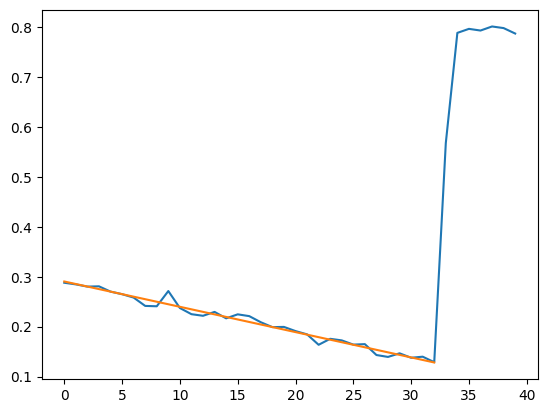

In [115]:
df_ = train_df[train_df['city'].isin(leaky_cities)].copy()
df_['cool_feature'] = df_.groupby('faculty').cumcount() / (df_.groupby('faculty').transform('size'))
df_['cool_feature'] = discretizer.transform(df_[['cool_feature']])[:, 0]
import matplotlib.pyplot as plt
plt.plot(df_.groupby('cool_feature')['accepted'].mean())
plt.plot(distrib_fixer_df.index * mapl.index.max(), distrib_fixer.predict(distrib_fixer_df.index.to_numpy().reshape(-1, 1)))

In [64]:
train_df = train_df.drop(columns=['personal_statement'], axis=1)
test_df = test_df.drop(columns=['personal_statement'], axis=1)

In [ ]:
import hashlib
vs = []
vsg = []
g = ['M', 'F']
for gender in g:
    for age in train_df['age'].unique():
        for country in train_df['country'].unique():
            vs.append(hashlib.md5((gender + str(age) + country).encode(encoding='UTF-8')).hexdigest())
            vsg.append(gender)

In [72]:
a = (train_df['sociodemographics'].apply(lambda x: vsg[vs.index(x)]) == 'M').astype(float)

In [102]:
(a == processed_train_df['sociodemographics_6']).mean()

0.609

In [92]:
np.corrcoef(a, processed_train_df['sociodemographics_6'])

array([[1.        , 0.21798984],
       [0.21798984, 1.        ]])

In [85]:
processed_train_df.iloc[:, 23:30]

,sociodemographics_0,sociodemographics_1,sociodemographics_2,sociodemographics_3,sociodemographics_4,sociodemographics_5,sociodemographics_6
0,0,0,0,0,0,0,1
1,0,0,0,0,0,1,0
2,0,0,0,0,0,1,1
3,0,0,0,0,1,0,0
4,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...
95995,0,0,0,1,0,1,1
95996,0,1,0,1,0,0,1
95997,0,0,1,1,0,0,0
95998,0,0,0,0,1,0,0


In [73]:
# PASHALKO #5
binenc = BinaryEncoder(cols=['city', 'school', 'sociodemographics'])
ohenc = one_hot.OneHotEncoder(cols=['country', 'faculty', 'student_id_%', 'application_id_%'])
processed_train_df = ohenc.fit_transform(binenc.fit_transform(train_df))#.sample(frac=1, random_state=42)

In [ ]:
processed_train_df

,age,country_1,country_2,country_3,country_4,city_0,city_1,city_2,city_3,city_4,...,application_id_%_242,application_id_%_243,application_id_%_244,application_id_%_245,application_id_%_246,application_id_%_247,application_id_%_248,application_id_%_249,application_id_%_250,cool_feature
0,24,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,False
1,21,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,False
2,17,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,False
3,20,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,False
4,19,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95995,21,1,0,0,0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,False
95996,18,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,True
95997,18,1,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,False
95998,20,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,True


In [67]:
class Ensemble:
    def __init__(self, models):
        self.models = models
    
    def predict(self, X):
        predictions_weighted_sum = np.full(len(X), 0.0)
        weights_sum = 0
        for model, weight in self.models:
            predictions_weighted_sum += model.predict_proba(X)[:, 1] * weight
            weights_sum += weight
        return predictions_weighted_sum / weights_sum

In [68]:
def objective(trial, X, y):
    params = {
        'iterations': trial.suggest_int('iterations', 512, 4096), 
        'learning_rate': trial.suggest_float('learning_rate', 0.0005, 0.2, log=True), 
        'depth': trial.suggest_int('depth', 2, 10), 
        'min_child_samples': trial.suggest_int('min_child_samples', 4, 128), 
        'subsample': trial.suggest_float('subsample', 0.1, 1), 
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.1, 1), 
        'random_state': trial.suggest_categorical('random_state', [42])
    }

    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    cv_scores = np.empty(3)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = CatBoostClassifier(**params, verbose=0)
        model.fit(
            X_train,
            y_train
        )
        preds = model.predict_proba(X_test)[:, 1]
        cv_scores[idx] = roc_auc_score(y_test, preds)

    return np.mean(cv_scores)

In [69]:
# processed_train_df_lite = processed_train_df.sample(n=1200).reset_index(drop=True)

# study = optuna.create_study(direction="maximize", study_name="CatBoostClassifier")
# func = lambda trial: objective(trial, processed_train_df_lite.drop(columns=['accepted'], axis=1), processed_train_df_lite['accepted'])
# study.optimize(func, n_trials=128)

In [70]:
# cb_best_params = study.best_params
cb_best_params = {
    'iterations': 2704,
    'learning_rate': 0.009275107961594345,
    'depth': 4,
    'min_child_samples': 113,
    'subsample': 0.38610748462168143,
    'colsample_bylevel': 0.11896837794321066,
    'random_state': 42
}
cb_best_params

{'iterations': 2704,
 'learning_rate': 0.009275107961594345,
 'depth': 4,
 'min_child_samples': 113,
 'subsample': 0.38610748462168143,
 'colsample_bylevel': 0.11896837794321066,
 'random_state': 42}

In [71]:
main_model = Ensemble([
    [CatBoostClassifier(**cb_best_params, verbose=0).fit(processed_train_df.drop(columns=['accepted'], axis=1), processed_train_df['accepted']), 1.0], 
])

KeyboardInterrupt: 

In [83]:
sub_models = {}
sub_binenc = BinaryEncoder(cols=['city', 'school', 'sociodemographics'])
sub_ohenc = one_hot.OneHotEncoder(cols=['country', 'faculty', 'student_id_%', 'application_id_%'])
sub_ohenc.fit(sub_binenc.fit_transform(train_df.drop(columns=['cool_feature'], axis=1)))
for feat_value in tqdm.tqdm(train_df['cool_feature'].unique()):
    train_df_part = train_df[train_df['cool_feature'] == feat_value].drop(columns=['cool_feature'], axis=1)
    train_df_part = sub_ohenc.transform(sub_binenc.transform(train_df_part))
    sub_models[feat_value] = Ensemble([
        [CatBoostClassifier(**cb_best_params, verbose=0).fit(train_df_part.drop(columns=['accepted'], axis=1), train_df_part['accepted']), 1.0], 
    ])

100%|██████████| 2/2 [00:09<00:00,  4.98s/it]


In [84]:
test_df['accepted'] = np.full(len(test_df), 0)
sample_submission['accepted'] = main_model.predict(ohenc.transform(binenc.transform(test_df.drop(columns=['ID'], axis=1))).drop(columns=['accepted'], axis=1))

In [85]:
for i in tqdm.tqdm(test_df.index):
    general_proba = sample_submission['accepted'][i]
    sub_proba = sub_models[test_df['cool_feature'][i]].predict(sub_ohenc.transform(sub_binenc.transform(test_df.loc[[i], :].drop(columns=['ID', 'cool_feature'], axis=1))).drop(columns=['accepted'], axis=1))
    if test_df['cool_feature'][i] == True: # upper
        sample_submission['accepted'][i] = (general_proba * 0.5 + sub_proba * 0.5) / (0.5 + 0.5)
    elif test_df['cool_feature'][i] == False: # lower
        if (test_pos[i] <= distrib_fixer_max) and (test_df['city'][i] in leaky_cities):
            fix = distrib_fixer.predict([[test_pos[i]]])[0]
            sample_submission['accepted'][i] = (general_proba * 1.0 + sub_proba * 1.0 + fix * 1.0) / (1.0 + 1.0 + 1.0)
        else:
            sample_submission['accepted'][i] = (general_proba * 0.5 + sub_proba * 0.5) / (0.5 + 0.5)

100%|██████████| 24000/24000 [05:43<00:00, 69.86it/s]


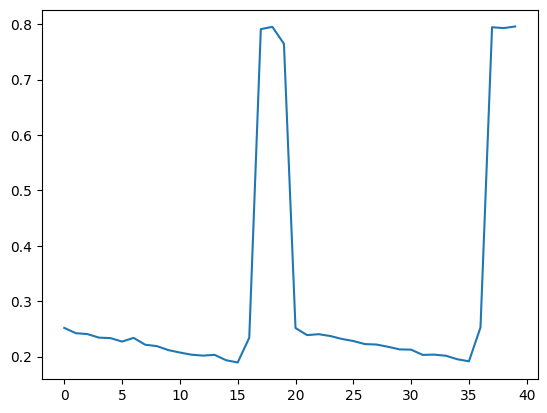

In [86]:
df_ = test_df[test_df['city'].isin(leaky_cities)].copy()
df_['accepted'] = sample_submission['accepted']
df_['cool_feature'] = df_.groupby('faculty').cumcount() / (df_.groupby('faculty').transform('size'))
df_['cool_feature'] = discretizer.transform(df_[['cool_feature']])[:, 0]
import matplotlib.pyplot as plt
plt.plot(df_.groupby('cool_feature')['accepted'].mean())

In [87]:
for i in tqdm.tqdm(test_df.index):
    aplid = test_df['application_id'][i]
    socdem = test_df['sociodemographics'][i]
    trrel = train_df[(train_df['application_id'] == aplid) & (train_df['sociodemographics'] == socdem)]
    if len(trrel) == 1:
        if trrel['accepted'].iloc[0] == 0:
            sample_submission['accepted'][i] = 1.0
            continue
        elif trrel['accepted'].iloc[0] == 1:
            sample_submission['accepted'][i] = 0.0
            continue
    elif len(trrel) == 0:
        tsrel = test_df[(test_df['application_id'] == aplid) & (test_df['sociodemographics'] == socdem)]
        if len(tsrel) == 2:
            pp0 = sample_submission['accepted'][tsrel.index[0]]
            pp1 = sample_submission['accepted'][tsrel.index[1]]
            sample_submission['accepted'][tsrel.index[0]] = pp0 - ((pp0 + pp1 - 1) / 2)
            sample_submission['accepted'][tsrel.index[1]] = pp1 - ((pp0 + pp1 - 1) / 2)
            continue

100%|██████████| 24000/24000 [03:46<00:00, 106.09it/s]


In [88]:
sample_submission['accepted'][(test_df['test_score'] % 1) != 0] = 1

In [89]:
sample_submission.to_csv('submission.csv', index=False)

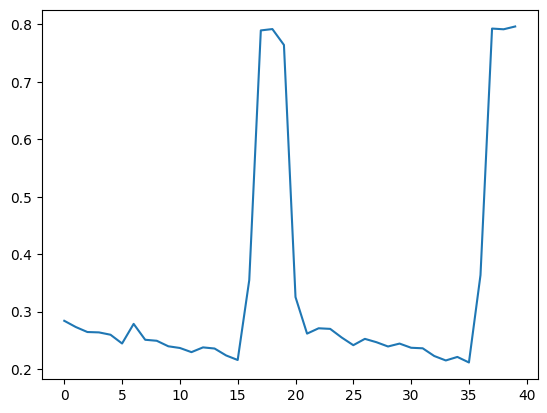

In [90]:
df_ = test_df[test_df['city'].isin(leaky_cities)].copy()
df_['accepted'] = sample_submission['accepted']
df_['cool_feature'] = df_.groupby('faculty').cumcount() / (df_.groupby('faculty').transform('size'))
df_['cool_feature'] = discretizer.transform(df_[['cool_feature']])[:, 0]
import matplotlib.pyplot as plt
plt.plot(df_.groupby('cool_feature')['accepted'].mean())